In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Ellipse
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import croissant as cro
import healpy as hp
from astropy.time import Time
from hera_filters import dspec


%matplotlib widget

In [2]:
d = np.load("sim_v001.npz")
for k, v in d.items():
    print(k, v.shape)

freqs = d["freqs"] / 1e6  # mhz
az, alt = d["azalts"].T
data = d["data"]
times = d["times"]  # jd
tx_crds = d["tx_crds_topo"][:, 0]
tx_flux = d["tx_flux"][0]

# az and alt both go 0-2pi which is unneccsary
data = data[:, alt <= np.pi]
az = az[alt <= np.pi]
alt = alt[alt <= np.pi]

# remove the last time which would mess up time averages (double counting since first == last)
data = data[:-1]
times = times[:-1]

# mask transmitter channels
tx_freq = freqs[::16]
tx_mask = np.zeros(data.shape, dtype=bool)
tx_mask[:, :, ::16] = True
print(tx_freq)
data = np.ma.array(data, mask=tx_mask)
tx_mask_1d = tx_mask[0, 0]

freqs (201,)
data (48, 324, 201)
azalts (324, 2)
times (48,)
tx_crds_topo (3, 1)
tx_flux (1, 201)
[ 50.  66.  82.  98. 114. 130. 146. 162. 178. 194. 210. 226. 242.]


In [3]:
tstart, tstop = Time([times[0], times[-1]], format="jd").to_datetime()
print(tstart, tstop)
extent = [freqs[0], freqs[-1], tstop, tstart]

def waterfall(data, log=False, vmin=None, vmax=None, aspect="auto", extent=extent, interpolation="none", cmap="plasma", title=None):
    if log:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.figure()
    plt.imshow(data, aspect=aspect, extent=extent, interpolation=interpolation, cmap=cmap, norm=norm)
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

2024-10-17 18:00:00 2024-10-18 17:29:21.702146


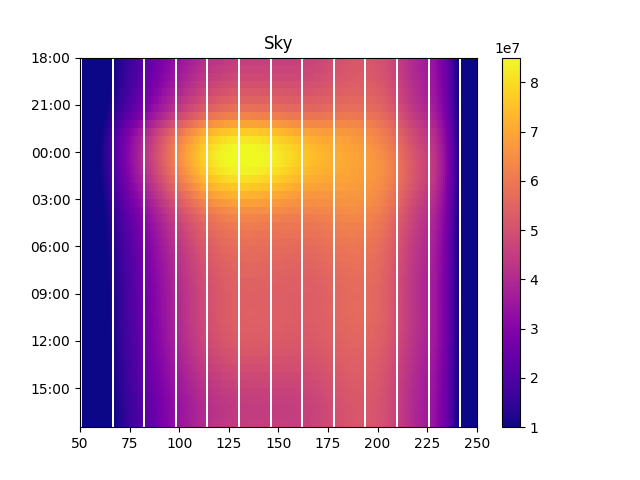

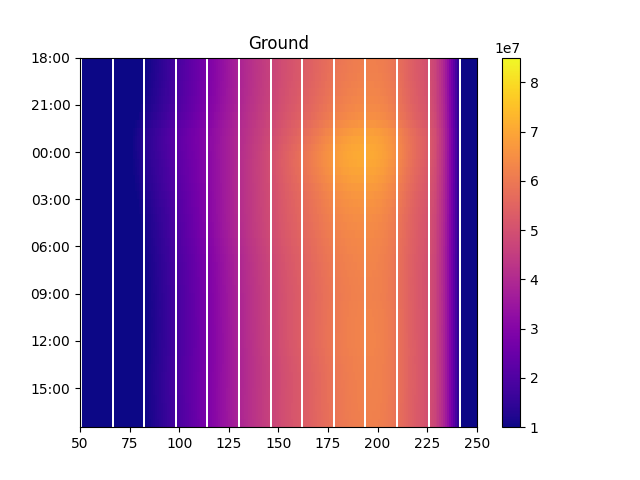

In [4]:
waterfall(data[:, 0], log=False, vmin=1e7, vmax=8.5e7, title="Sky")
waterfall(data[:, -18], log=False, vmin=1e7, vmax=8.5e7, title="Ground")

### Beam Mapping

First, we assume that the transmitter is so much brighter than the sky and the ground that we can directly use it to probe the beam wihtout models of the ground and the sky. That is, at transmitter frequencies, the contributions from the sky and the ground are negligible. This is likely incorrect, guess is 1-10% contribution. Might be able to correct contribution iteratively by leveraging time information etc but we will see. Or once we have the first iteration of the beam model to put in a sky and ground model and adjust that way. If contribution is too large then the next step can be to do gradient descent on a full forward model with CROISSANT.

Note here that we think of the beam as the product of the beam directivity and the gain/bandpass/beam efficiency. The beam in this interpretation introduces frequency dependent multiplicative gain which distorts shapes. Need to get that calibrated out of course, as it changes the shape of monopole signals.

We use the time averaged spectra first as they remove non-monopole components of the sky. (Actually, m=0 components stays, but unclear how much it matters given the horizon.)

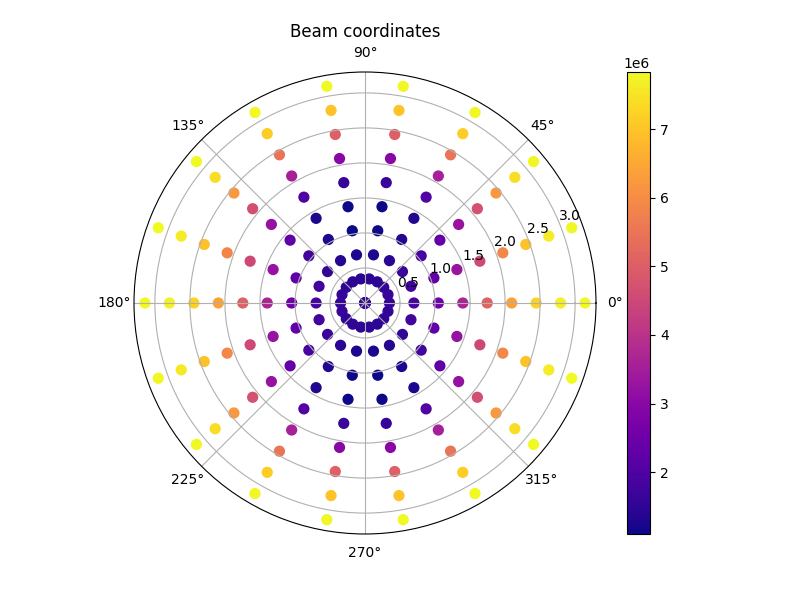

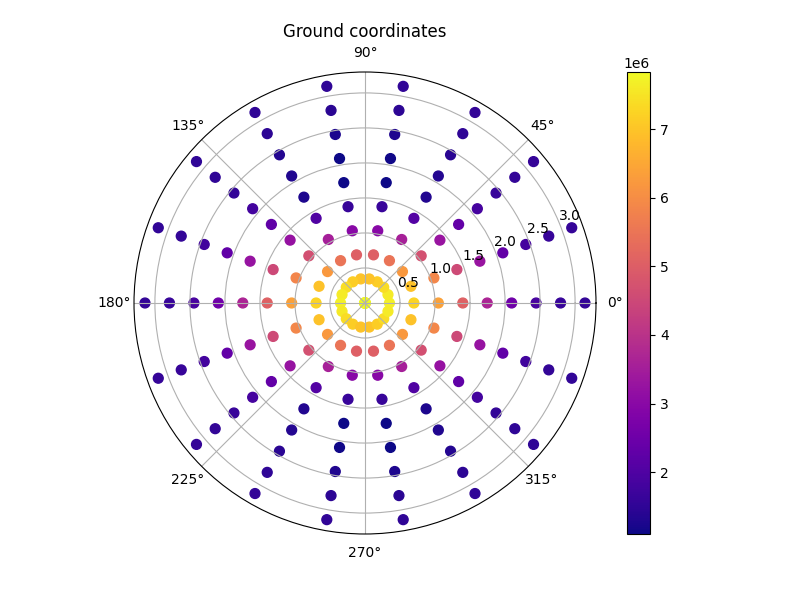

In [5]:
tx_data = data.data[..., ::16].mean(axis=0) # angle, freq
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 6))
sc = ax.scatter(az, alt, c=tx_data[..., 0], cmap="plasma", s=50)
plt.colorbar(sc, ax=ax, label="")
ax.set_title("Beam coordinates", pad=25)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 6))
sc = ax.scatter(az, np.pi-alt, c=tx_data[..., 0], cmap="plasma", s=50)
plt.colorbar(sc, ax=ax, label="")
ax.set_title("Ground coordinates", pad=25)
plt.show()

In [6]:
# need to convert data shape to croissant compatible: freq, theta, phi
phi = np.unique(az)
theta = np.pi - np.unique(alt)  # zenith is 0
tx_cro = tx_data.T.reshape(-1, theta.size, phi.size)
# need to reverse theta direction to get increasing
theta = theta[::-1]
tx_cro = tx_cro[:, ::-1]
nside = 16
npix = hp.nside2npix(nside)
hp_dA = 4 * np.pi / npix  # the surface area element on the sphere, for integrals. this is the area of one pixel
beam_mdl = cro.healpix.grid2healpix(tx_cro, nside, theta=theta, phi=phi)

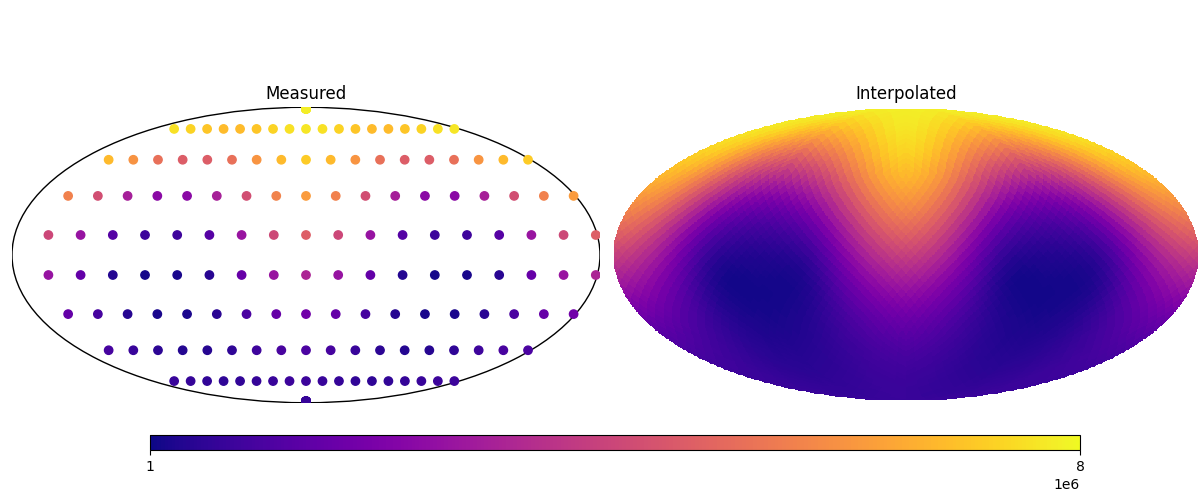

In [7]:
vmin = 1e6
vmax = 8e6
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = "plasma"
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

fig = plt.figure(figsize=(12, 5))
hp.mollview(np.zeros_like(beam_mdl[0]), fig=fig, cmap="gray_r", title="Measured", cbar=False, min=0, max=1, sub=(1, 2, 1))
ax1 = plt.gca()
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
width = xlim[1] - xlim[0]
height = ylim[1] - ylim[0]
center = (np.mean(xlim), np.mean(ylim))
outline = Ellipse(xy=center, width=width, height=height, edgecolor='black', facecolor='none')
ax1.add_patch(outline)
hp.projscatter(np.pi-alt, az, c=tx_data[:, 0], cmap=cmap, norm=norm)
hp.mollview(beam_mdl[0], fig=fig, cmap=cmap, title="Interpolated", min=vmin, max=vmax, cbar=False, sub=(1, 2, 2))
ax2 = plt.gca()
plt.subplots_adjust(bottom=0.2, top=0.95)
cbar_ax = fig.add_axes([0.125, 0.1, 0.775, 0.03])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal", ticks=[vmin, vmax])#shrink=0.75, aspect=25, fraction=0.1, pad=0.05, ticks=[vmin, vmax])
plt.show()

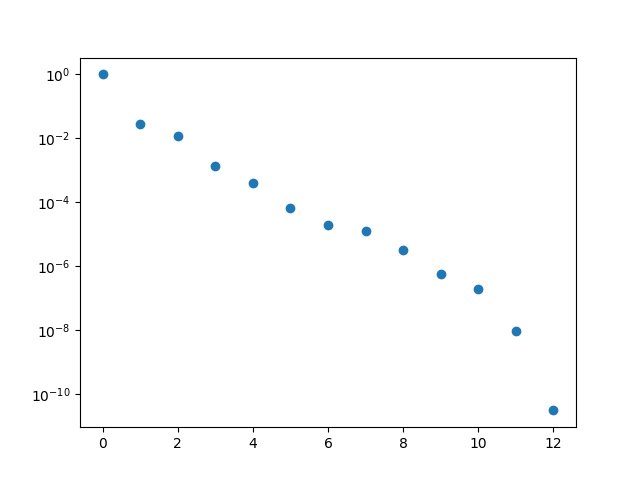

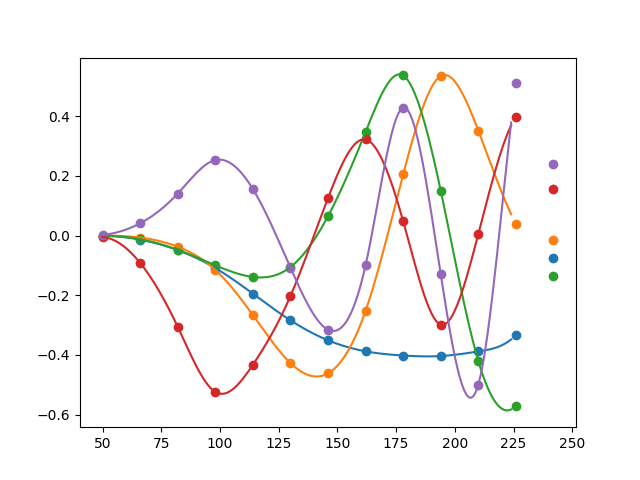

In [9]:
fmax = 225
fmask = freqs < fmax
fcut = freqs[fmask]
datacut = data[..., fmask]
tx_mask_1dcut = tx_mask_1d[fmask]

cov = beam_mdl @ beam_mdl.T
u, s, vt = np.linalg.svd(cov)
plt.figure()
plt.plot(s/s[0], marker="o", ls="none")
plt.yscale("log")
plt.show()

# plt.figure()
# plt.plot(vt[:5].T)
# plt.show()

plt.figure()
pca_interp = np.empty((len(vt), fcut.size))
for i, evec in enumerate(vt):
#    pca_interp[i] = np.polyval(np.polyfit(tx_freq, evec, i+2), freqs)
    pca_interp[i] = interp1d(tx_freq, evec, kind="cubic")(fcut)
    if i < 5:
        plt.scatter(tx_freq, evec)
        plt.plot(fcut, pca_interp[i])
plt.show()

In [10]:
# pca_interp is A.t, 
# do lls fit on tx freq subset of pca_interp (vt), LLS = inv(At @ A) @ At @ beam_mdl
Amat = vt.T
pca_params = np.linalg.inv(Amat.T @ Amat) @ Amat.T @ beam_mdl
print(pca_params.shape)
# then A @ fit -> interpolation
full_A = pca_interp.T
beam_full = full_A @ pca_params
print(beam_full.shape)

(13, 3072)
(175, 3072)


In [39]:
# normalize beam so it doesn't change total power sans ground loss effect
bandpass = beam_full.sum(axis=1) * hp_dA
beam = beam_full / bandpass[:, None]

#plt.figure()
#plt.plot(fcut, bandpass)
#plt.yscale("log")
#plt.show()

#waterfall(datacut[:, 0] / bandpass, log=False)#, vmin=1e7, vmax=8.5e7)
#waterfall(datacut[:, -18] / bandpass, log=False)

In [12]:
plt.close("all")

Trying to separate the sky and the ground. Since we're doing the time average, we should be mostly monpole signal. That is, denoting the average beam above (below) the horizon by $A^+$ ($A^-$), we get

$$T_{\rm up} = T_{\rm gsm, mono} A^+ + T_{\rm gnd} A^- $$
$$T_{\rm down} = T_{\rm gsm, mono} A^- + T_{\rm gnd} A^+ $$

This is not exact because there are other parts of the sky that do not move with time besides the monopole, but it's probably pretty good. Actually, averaging over azimuthal angle would improve this further so we are also doing that.

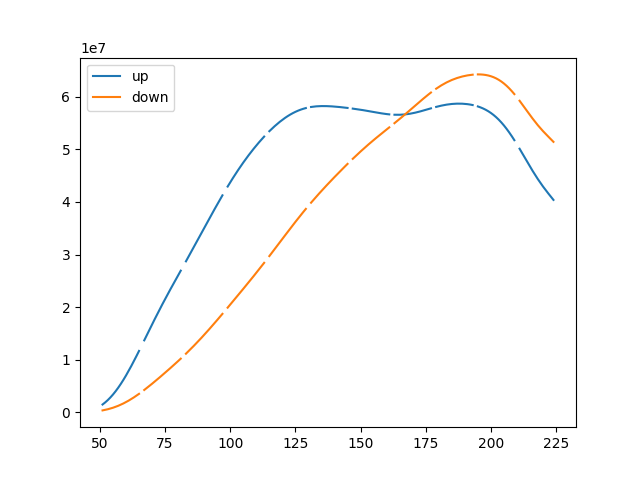

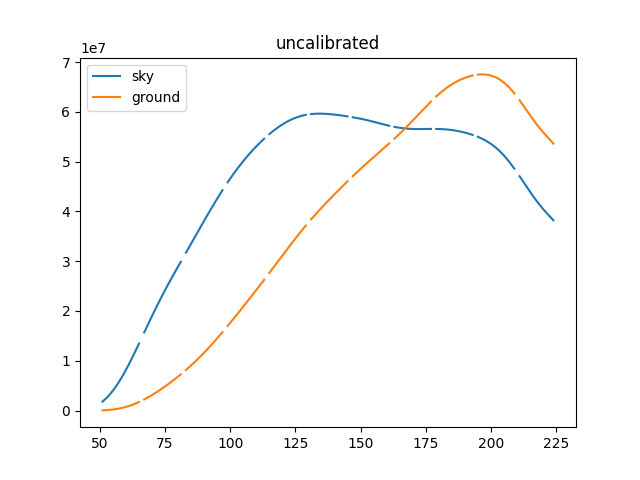

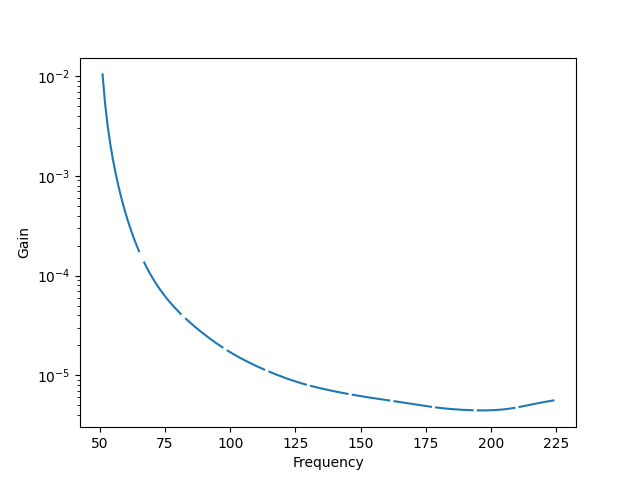

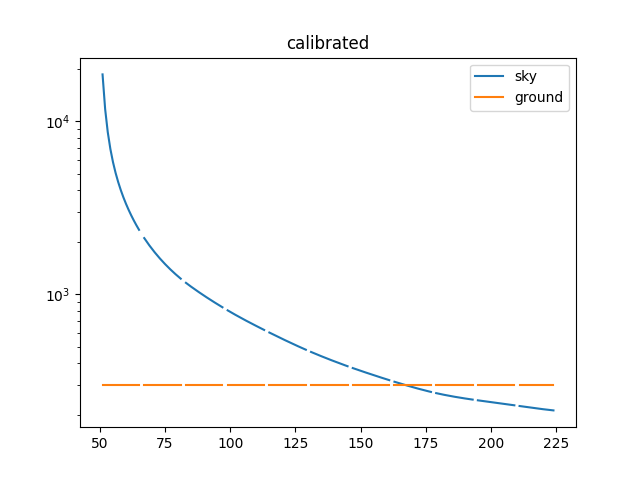

In [16]:
T_up = datacut.data[:, :18].mean(axis=(0, 1))# / bandpass
T_down = datacut.data[:, -18:].mean(axis=(0, 1))# / bandpass

T_up = np.ma.array(T_up, mask=tx_mask_1dcut)
T_down = np.ma.array(T_down, mask=T_up.mask)

# there's clearly sky present here
plt.figure()
plt.plot(fcut, T_up, label="up")
plt.plot(fcut, T_down, label="down")
plt.legend()
plt.show()

# since we're time and azimuth averaged, the sky is ~ monopole
beam_th, beam_ph = hp.pix2ang(nside, np.arange(npix), lonlat=False)
# HORIZON_THETA = np.pi /2 
#HORIZON_THETA = np.pi/3  # 60 degrees 
HORIZON_THETA = np.deg2rad(105)
Aplus = beam_full[:, beam_th <= HORIZON_THETA].sum(axis=1) / beam_full.sum(axis=1)
Aminus = beam_full[:, beam_th > HORIZON_THETA].sum(axis=1) / beam_full.sum(axis=1)
# we can invert the equation above in our heads of course
inv_mixing = np.array([[Aplus, -Aminus], [-Aminus, Aplus]]) / (Aplus**2 - Aminus**2)
T_comp = np.einsum("ijf, jf -> if", inv_mixing, np.array([T_up.data, T_down.data]))
sky_mono_spec = np.ma.array(T_comp[0], mask=T_up.mask)
gnd_spec = np.ma.array(T_comp[1], mask=T_up.mask)

plt.figure()
plt.plot(fcut, sky_mono_spec, label="sky")
plt.plot(fcut, gnd_spec, label="ground")
plt.title("uncalibrated")
plt.legend()
plt.show()

T_GND = 300 # just an assumption but at most we're off by a freq independent scale
gain = T_GND / gnd_spec

plt.figure()
plt.plot(fcut, gain)
plt.ylabel("Gain")
plt.xlabel("Frequency")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(fcut, sky_mono_spec * gain, label="sky")
plt.plot(fcut, gnd_spec * gain, label="ground")
plt.title("calibrated")
plt.legend()
plt.yscale("log")
plt.show()

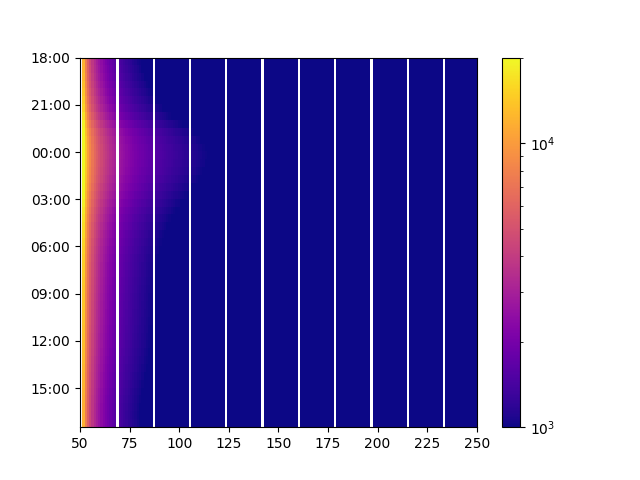

In [17]:
cal_data = datacut * gain[None, None, :]
waterfall(cal_data[:, 0], log=True, vmin=1e3, vmax=2e4)

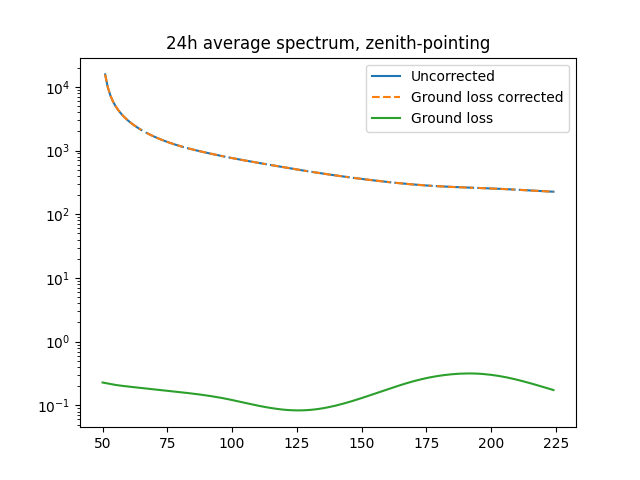

In [18]:
gnd_signal = Aminus * T_GND * hp_dA
sky_data = cal_data[:, 0] - gnd_signal

plt.figure()
plt.plot(fcut, cal_data[:, 0].mean(axis=0), label="Uncorrected")
plt.plot(fcut, sky_data.mean(axis=0), ls="--", label="Ground loss corrected")
plt.plot(fcut, gnd_signal, label="Ground loss")
plt.legend()
plt.title("24h average spectrum, zenith-pointing")
plt.yscale("log")
plt.show()

When we're pointing down, the signal at transmitter frequencies is the sum of:
- zenith beam X transmitter power
- above horizon beam X ground
- below horizon beam X sky

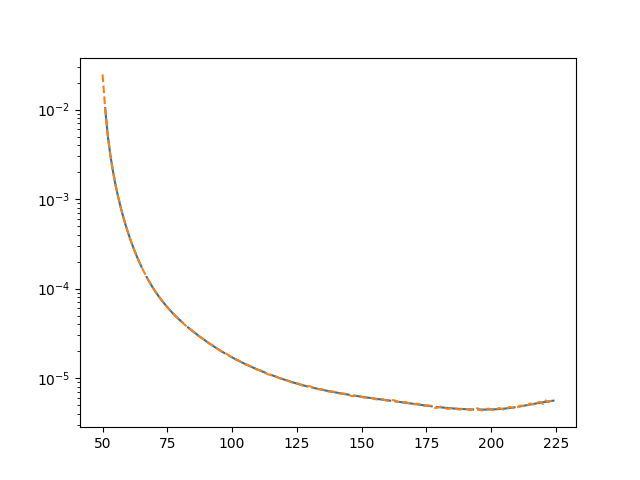

In [28]:
# first we need to interpolate the gain model
weights = np.logical_not(gain.mask).astype(int)
gain_mdl, res, info = dspec.fourier_filter(fcut/1e3, gain.data, weights, [0], [200], "dpss_solve", eigenval_cutoff=[1e-12])

plt.figure()
plt.plot(fcut, gain)
plt.plot(fcut, gain_mdl, ls="--")
plt.yscale("log")
plt.show()

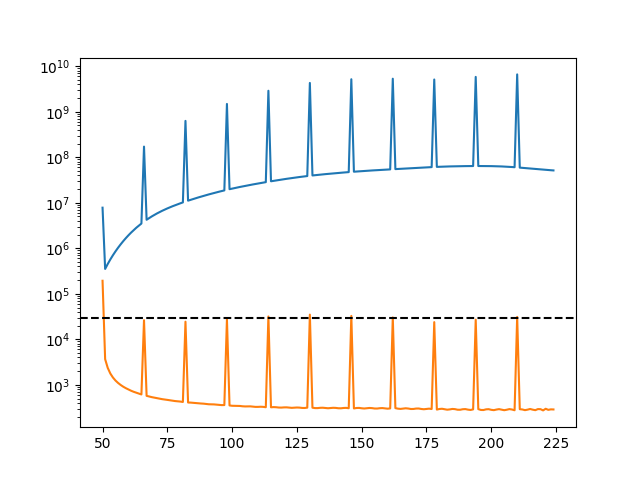

In [38]:
plt.figure()
plt.plot(fcut, T_down.data)
plt.plot(fcut, T_down.data * gain_mdl)
plt.axhline(np.mean((T_down.data * gain_mdl)[::16][1:]), ls="--", c="k")
plt.yscale("log")
plt.show()

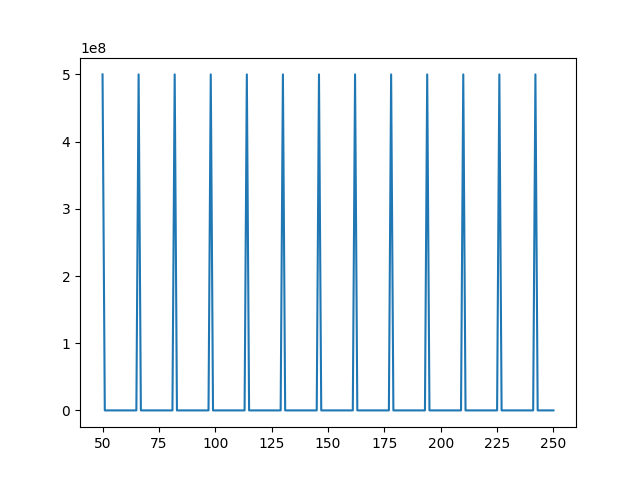

In [8]:
plt.figure()
plt.plot(freqs, tx_flux)
plt.show()

0.0 180.0


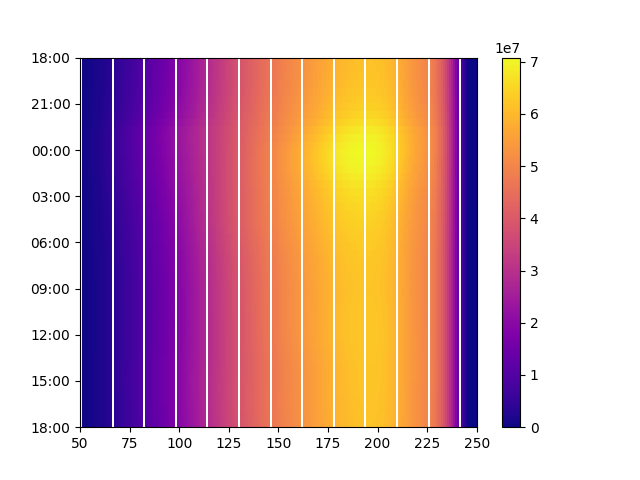

In [9]:
# ground temp as absolute calibration
print(np.rad2deg(az[-18]), np.rad2deg(alt[-18]))
waterfall(data[:, -18, :], log=False)

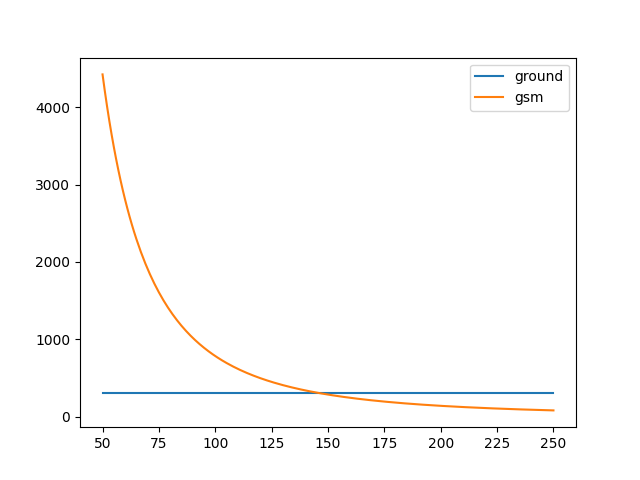

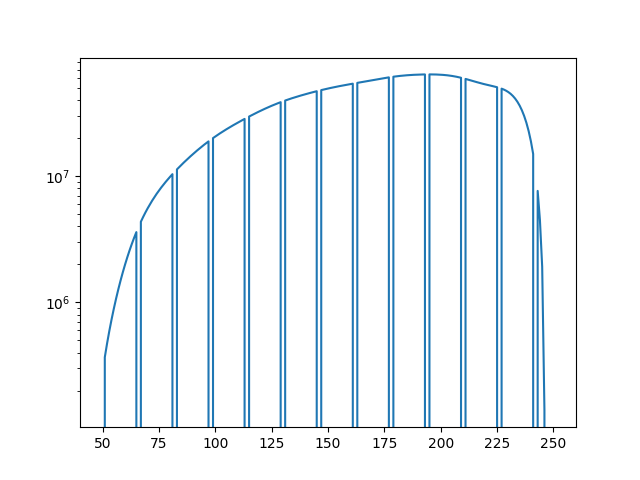

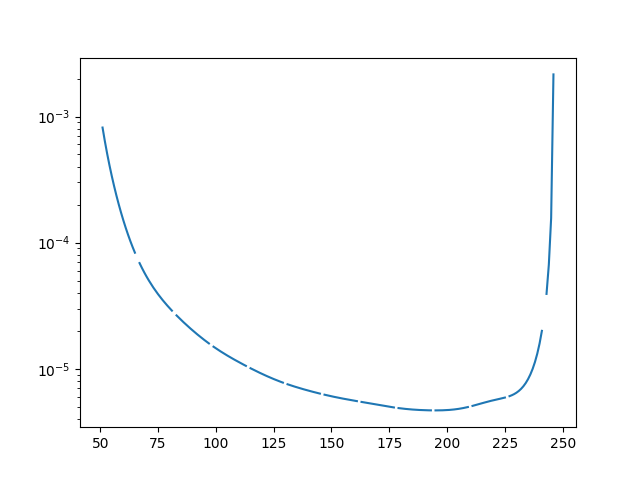

In [14]:
T_gnd = 300  # guess
T_gsm_mono = 180 * (freqs/180)**(-2.5)
plt.figure()
plt.plot(freqs, np.full_like(freqs, T_gnd), label="ground")
plt.plot(freqs, T_gsm_mono, label="gsm")
plt.legend()
plt.show()
# sky contribution is mostly monopole if we avg, so since we're looking down we should be mostly OK
t_avg = data[:, -18].mean(axis=0)
plt.figure()
plt.plot(freqs, t_avg.data)
plt.yscale("log")
plt.show()

# fractional contribution of sky is ~ 1 %, NOTE: THIS IS FREQ DEPENDENT
#fsky = 1e-2
fsky = 0  # turn off sky
t_cal = (1-fsky) * T_gnd + fsky * T_gsm_mono
gain = t_cal / t_avg
plt.figure()
plt.plot(freqs, gain)
plt.yscale("log")
plt.show()

In [15]:
# use dpss to fit gain from 50 to 225
fmin = 50
fmax = 225
fmask = (freqs >= fmin) & (freqs <= fmax)

fcut = freqs[fmask]
gain = gain[fmask]
weights = np.ones(fcut.size)
weights[::16] = 0  # tx freqs

mdl, res, info = hera_filters.dspec.fourier_filter(fcut/1e3, gain.data, weights, [0], [200], "dpss_solve", eigenval_cutoff=[1e-12])

print(info)

{'status': {'axis_0': {}, 'axis_1': {0: 'success'}}, 'filter_params': {'axis_0': {}, 'axis_1': {'method': 'solve', 'basis': 'dpss', 'filter_centers': [0], 'filter_half_widths': [200], 'suppression_factors': [1e-09], 'basis_options': {'eigenval_cutoff': [1e-12]}, 'mode': 'dpss_solve'}}}


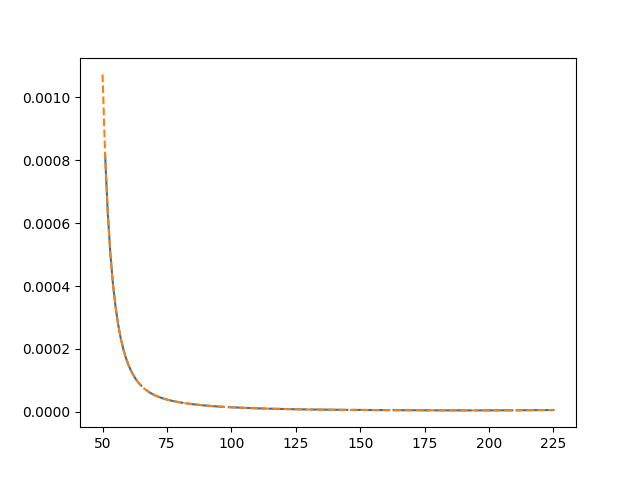

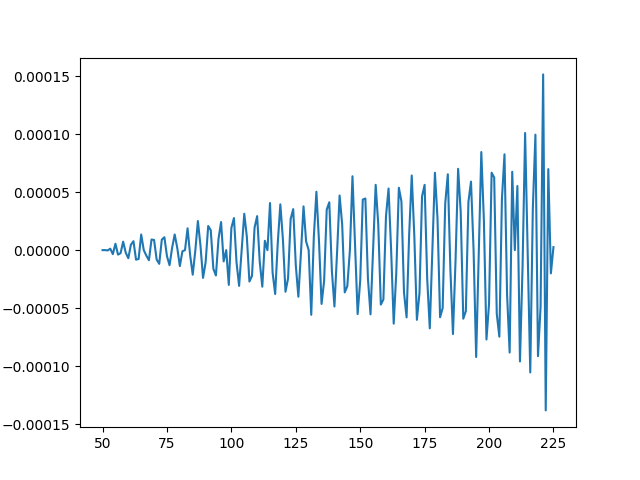

In [16]:
plt.figure()
plt.plot(fcut, gain)
plt.plot(fcut, mdl, ls="--")
plt.show()

plt.figure()
plt.plot(fcut, res/gain.data)
plt.show()

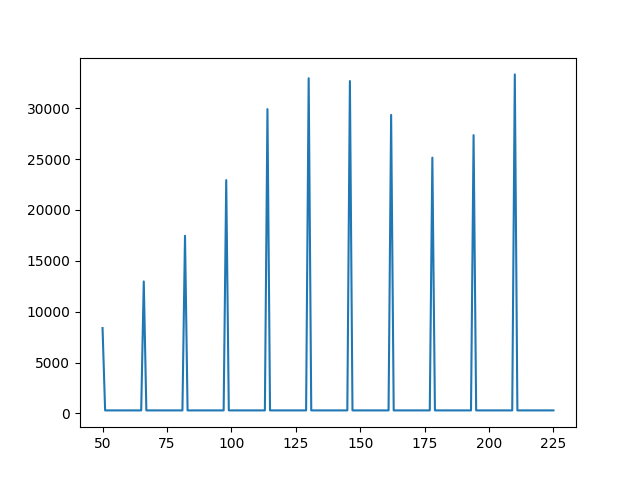

In [17]:
cal_data = data.data[:, :, fmask] * mdl

plt.figure()
plt.plot(fcut, cal_data[:, -18].mean(axis=0))
plt.show()